# Grade Bonus Task

In your grade bonus task, you will investigate what **Bonus Certificates** are and how to price them. You may ignore credit risk considerations. Moreover, assumem any fraction of securities is tradable at any time and that riskless return of the Bank account is given by r = 2% p.a.


### **Task 1:** Plot the evolution of the stock and the log-returns and investigate their mean, std, minimum, maximum and their quartiles

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
data = pd.read_csv("Telekom.csv", header = 0)

In [17]:
data.head()

,Date,Close
0,2014-06-17,12.585
1,2014-06-18,12.660
2,2014-06-19,12.800
3,2014-06-20,12.735
4,2014-06-23,12.675


In [18]:
data.columns

Index(['Date', 'Close'], dtype='object')

In [19]:
data.dtypes

Date      object
Close    float64
dtype: object

In [20]:
# Date to DateTime
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Close
0,2014-06-17,12.585
1,2014-06-18,12.660
2,2014-06-19,12.800
3,2014-06-20,12.735
4,2014-06-23,12.675


In [21]:
data.set_index('Date', inplace=True)
data.head()

,Close
Date,
2014-06-17,12.585
2014-06-18,12.660
2014-06-19,12.800
2014-06-20,12.735
2014-06-23,12.675


Text(0, 0.5, 'Value $')

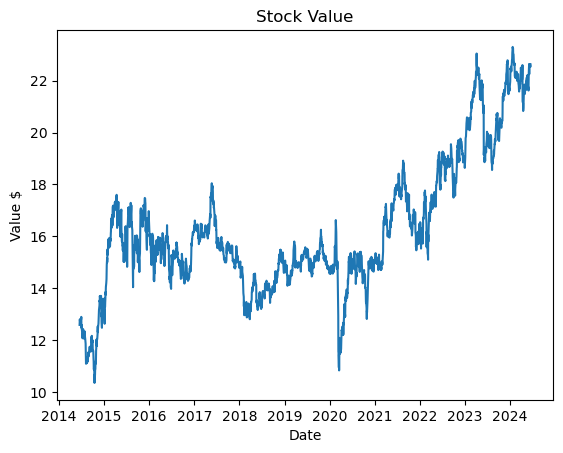

In [22]:
plt.title("Stock Value")
plt.plot(data["Close"])
plt.xlabel("Date")
plt.ylabel("Value $")

In [23]:
mean = data["Close"].mean()
std_daily = data["Close"].std()
std_annual = std_daily * np.sqrt(225)
minimum = data["Close"].min()
maximum = data["Close"].max()
q1 = data["Close"].quantile(0.25)
q2 = data["Close"].quantile(0.50)  # median value
q3 = data["Close"].quantile(0.75)
print("=== Stock Price Statistics ===")
print(f"Mean:                  {mean:.2f}")
print(f"Daily Std Dev:         {std_daily:.2f}")
print(f"Annualized Std Dev:    {std_annual:.2f}")
print(f"Minimum:               {minimum:.2f}")
print(f"Maximum:               {maximum:.2f}")
print(f"1st Quartile (Q1):     {q1:.2f}")
print(f"Median (Q2):           {q2:.2f}")
print(f"3rd Quartile (Q3):     {q3:.2f}")


=== Stock Price Statistics ===
Mean:                  16.28
Daily Std Dev:         2.59
Annualized Std Dev:    38.88
Minimum:               10.35
Maximum:               23.30
1st Quartile (Q1):     14.77
Median (Q2):           15.64
3rd Quartile (Q3):     17.48


Now let us plot the log returns:

$$
r_t = ln\left(\frac{P_{t+i}}{P_t}\right) = ln(P_{t+1})-ln(P_t)
$$



Text(0, 0.5, 'Log Return')

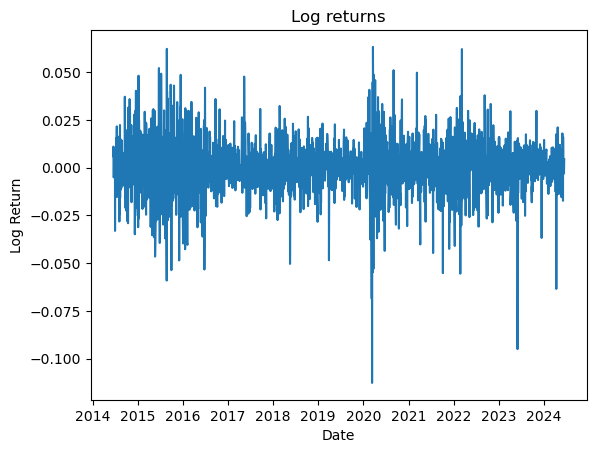

In [24]:
data["LogReturn"] = np.log(data['Close']).diff()
data.head()
plt.title("Log returns")
plt.plot(data["LogReturn"])
plt.xlabel("Date")
plt.ylabel("Log Return")

In [25]:
log_returns = data['LogReturn'].dropna()

# Mean log-returns (per day)
mean_log_return = log_returns.mean()
 # remove the NaN values
n_days = len(log_returns)

# Daily std (volatilidad diaria)
daily_vol = log_returns.std(ddof=1)

# annualzied now
annual_vol = daily_vol * np.sqrt(252)

# maybe extra stats
min_log_return = log_returns.min()
max_log_return = log_returns.max()
q1_log_return = log_returns.quantile(0.25)
q2_log_return = log_returns.quantile(0.50)
q3_log_return = log_returns.quantile(0.75)


print("=== Log Return Statistics ===")
print(f"Mean daily log return:     {mean_log_return:.6f}")
print(f"Daily volatility (std):    {daily_vol:.6f}")
print(f"Annualized volatility:     {annual_vol:.6f}")
print(f"Minimum:                   {min_log_return:.6f}")
print(f"Maximum:                   {max_log_return:.6f}")
print(f"1st Quartile (Q1):         {q1_log_return:.6f}")
print(f"Median (Q2):               {q2_log_return:.6f}")
print(f"3rd Quartile (Q3):         {q3_log_return:.6f}")


=== Log Return Statistics ===
Mean daily log return:     0.000231
Daily volatility (std):    0.013379
Annualized volatility:     0.212393
Minimum:                   -0.112673
Maximum:                   0.063141
1st Quartile (Q1):         -0.005909
Median (Q2):               0.000000
3rd Quartile (Q3):         0.007092


Let's compute now the drawdowns of the stock prices

In [26]:
def drawdown(prices_series: pd.Series):
    """Takes a time series of asset prices.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    return_series = prices_series.pct_change()
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

data_drawdown = drawdown(data["Close"])
data_drawdown.head()


,Wealth,Previous Peak,Drawdown
Date,,,
2014-06-17,NaN,NaN,NaN
2014-06-18,1005.959460,1005.959460,0.000000
2014-06-19,1017.083842,1017.083842,0.000000
2014-06-20,1011.918921,1017.083842,-0.005078
2014-06-23,1007.151383,1017.083842,-0.009766


In [27]:
plt.plot(data_drawdown["Drawdown"])
print(f"Maximum Drawdown: {data_drawdown["Drawdown"].min()}")

SyntaxError: f-string: unmatched '[' (763679846.py, line 2)

### **Task 2:** Fit a Black-Scholes model to the time series *Telekom.csv*

The **classical Black-Scholes model**, is given by: 
$$
dB_t = rB_tdt, B_0 =1
$$
$$
dP_t = P_t(bdt+\sigma dW_t), P_0 = p_0>0
$$
$$
P_t = P_0 \exp\left(b-\frac{1}{2}\sigma^2\right)t+\sigma W_t
$$
$$
b = \frac{E[\frac{P_{t+1}}{P_t}]}{\Delta t}+\frac{1}{2}\sigma^2
$$

In [ ]:
# annualized drift
mu_annual = mean_log_return * 252 + 0.5 * annual_vol**2
print(f"Estimated μ (drift) annualized: {mu_annual:.6f}")
print("Estimated Black-Scholes Parameters")
print(f"Mean daily log return:       {mean_log_return:.6f}")
print(f"Daily volatility (σ):        {daily_vol:.6f}")
print(f"Annualized volatility (σ):   {annual_vol:.6f}")



Estimated μ (drift) annualized: 0.080770
Estimated Black-Scholes Parameters
Mean daily log return:       0.000231
Daily volatility (σ):        0.013379
Annualized volatility (σ):   0.212393


### 

### **Task 3:** What are Bonus Certificates? Draw their payoff profile. Why would an investor buy any of those certificates? Which risks should be considered?

Explicar riegos y dos tipos de bonus certificates

<!-- A **Bonus Certificate** is a structured financial product that allows investors to benefit from moderate upward movements of the underlying asset while offering partial downside protection. It typically includes a fixed interest component and guarantees a predefined bonus payout at maturity, provided that the underlying asset never breaches a specified lower barrier during the product’s life.

If the asset’s price remains above this safety threshold, the investor receives either the bonus amount or the final asset value, whichever is higher.

However, if the barrier is breached at any time, the protection mechanism is lost. From that moment on, the certificate behaves like a direct investment in the underlying asset, and the investor bears full downside risk without the right to the bonus payout. -->

In [ ]:
!pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import ipywidgets as widgets
from IPython.display import display

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def bonus_certificate_plot(BonusLevel=110, Barrier=70):
    P_T = np.linspace(50, 150, 500)
    P_0 = 100

    # Payoff  Bonus Certificate
    payoff = np.where(
        P_T >= Barrier,                    # Not touched barrier
        np.maximum(P_T, BonusLevel),      # Cobras el máximo entre precio final y bonus garantizado
        P_T                                # broken barrier once → stock owners
    )

    profit = payoff - P_0
    stock_profit = P_T - P_0

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(P_T, profit, label='Bonus Certificate Profit/Loss', color='blue')
    plt.plot(P_T, stock_profit, '--', label='Stock Profit/Loss', color='gray')

    # reference lines
    plt.axhline(0, color='black', linestyle='-')
    plt.axvline(Barrier, color='red', linestyle=':', label='Barrier (Safety Threshold)')
    plt.axhline(BonusLevel - P_0, color='green', linestyle='--', label='Minimum Guaranteed Profit')
    plt.axvline(BonusLevel, color='yellow', linestyle='--', label='Bonus Level (Payoff €)')

    plt.xlabel('Final Stock Price $P_T$')
    plt.ylabel('Profit / Loss')
    plt.title('Bonus Certificate vs Direct Stock Investment')
    plt.legend()
    plt.grid(True)
    plt.show()

# Widgets 
interactive_plot = widgets.interactive(
    bonus_certificate_plot,
    BonusLevel=(100, 130, 1),
    Barrier=(50, 100, 1)
)

display(interactive_plot)



interactive(children=(IntSlider(value=110, description='BonusLevel', max=130, min=100), IntSlider(value=70, de…

### **Task 4:** Find a portfolio of products you know from the lecture and the exercices that replicate the certificate.

To replicate the classic bonus certificate, we consider a **long position in the underlying** and a **down-and-out put option** with strike equal to the bonus level $K$ and barrier $B$.

- The **underlying** provides a payoff of $P_T$ at maturity.
- The **down-and-out put** pays $K - P_T$ if $P_T < K$ and the barrier $B$ has **not** been breached during the product's lifetime. Otherwise, it expires worthless.

Thus, the **total payoff** becom- If the barrier was not breached:  
  $$
  \text{Payoff} = (P_T + \max(K - P_T, 0)) - P_0 = \max(P_T, K) - P_0
  $$  
  which results in a **guaranteed minimum** of $K - P_0$.

- If the barrier was breached:  
  $$
  \text{Payoff} = P_T - P_0
  $$  
  and the product behaves like a direct investment in the stock.
in the stock.

This replication captures the core behavior of a classic bonus certificate: **capital protection up to the barrier** and linear participation otherwise.
pation otherwise.
 n otherwise.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Function to simulate GBM
def simulate_gbm(S0, T, N, mu, sigma):
    dt = T / N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N)
    W = np.insert(np.cumsum(np.sqrt(dt) * W), 0, 0)

    drift = mu  
    S = S0 * np.exp((drift - 0.5 * sigma**2) * t + sigma * W)
    return t, S

# Global variables
global_barrier_breached = None
global_final_price = None
global_P0 = 100

# Plot function with barrier
def plot_gbm_with_barrier(mu, sigma, T, N,  barrier, S0=global_P0):
    global global_barrier_breached, global_final_price

    t, S = simulate_gbm(S0, T, N, mu, sigma)
    breached = np.any(S < barrier)
    final_price = S[-1]

    # Store results
    global_barrier_breached = breached
    global_final_price = final_price

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(t, S, label='GBM Path')
    plt.axhline(y=barrier, color='red', linestyle='--', label=f'Barrier Level: {barrier}')
    plt.title("GBM Simulation with Barrier Check")
    plt.xlabel("Time (Years)")
    plt.ylabel("Stock Price")
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.grid(True)
    plt.show()

    if breached:
        print(f" Barrier was breached during the simulation.")
    else:
        print(f" Barrier was NOT breached.")
    print(f" Final Price: {final_price:.2f}")

# Interactive widget
interactive_gbm_barrier = widgets.interactive(
    plot_gbm_with_barrier,
    S0=widgets.FloatSlider(value=100, min=10, max=160, step=5, description='Initial Price'),
    mu=widgets.FloatSlider(value=0.05, min=-0.1, max=0.2, step=0.005, description='Drift μ'),
    sigma=widgets.FloatSlider(value=0.05, min=0.01, max=1.0, step=0.01, description='Volatility σ'),
    T=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Time (yrs)'),
    N=widgets.IntSlider(value=500, min=50, max=1000, step=10, description='Steps'),
    r=widgets.FloatSlider(value=0.02, min=0.0, max=0.1, step=0.005, description='Risk-Free Rate'),
    barrier=widgets.FloatSlider(value=90, min=0, max=200, step=1, description='Barrier Level')
)

display(interactive_gbm_barrier)


interactive(children=(FloatSlider(value=0.05, description='Drift μ', max=0.2, min=-0.1, step=0.005), FloatSlid…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
def plot_classic_bonus_replication(BonusLevel=110, BarrierLevel=90, P0=global_P0, BarrierBreached=global_barrier_breached, premium=5):
    """
    Interactive plot for replicating a Classic Bonus Certificate.

    Inputs:
    - BonusLevel: Strike price of the down-and-out put option.
    - BarrierLevel: Barrier below which the bonus protection is lost.
    - P0: Initial price of the underlying.
    - BarrierBreached: 'Yes' if the barrier was touched during the product's lifetime, 'No' otherwise.
    - premium: cost to buy the certificate
    """
    P_T = np.linspace(50, 190, 500)
    K = BonusLevel

    # Handle both global bool or widget string
    if isinstance(BarrierBreached, str):
        breached = BarrierBreached == 'Yes'
    else:
        breached = BarrierBreached

    stock_payoff = P_T
    put_payoff = np.zeros_like(P_T)

    if not breached:
        valid_region = P_T >= BarrierLevel
        put_payoff[valid_region] = np.maximum(K - P_T[valid_region], 0)
    else:
        valid_region = np.full_like(P_T, True, dtype=bool)

    total_payoff = np.where(valid_region, stock_payoff + put_payoff, np.nan)
    profit_total = total_payoff - P0 - premium
    stock_profit = P_T - P0

    plt.figure(figsize=(10, 5))
    plt.plot(P_T, profit_total, label='Bonus Certificate Replication', color='blue', linewidth=2)
    plt.plot(P_T, stock_profit, '--', label='Stock Only', color='gray')
    plt.axhline(0, color='black')
    plt.axvline(BonusLevel, color='green', linestyle='--', label='Bonus Level')
    plt.axvline(BarrierLevel, color='red', linestyle='--', label='Barrier Level')
    title = "No Barrier Breach (only $P_T \\geq$ Barrier)" if not breached else "Barrier Breached"
    plt.title(f'Classic Bonus Certificate Replication ({title})')
    plt.xlabel('Final Stock Price $P_T$')
    plt.ylabel('Profit / Loss')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.show()

# Interactive widget setup
interactive_plot_bonus_corrected = widgets.interactive(
    plot_classic_bonus_replication,
    BonusLevel=widgets.IntSlider(value=140, min=100, max=140, step=1),
    premium=widgets.IntSlider(value=5, min=0, max=20, step=1),
    BarrierLevel=widgets.IntSlider(value=70, min=70, max=100, step=1),
    P0=widgets.IntSlider(value=100, min=80, max=120, step=1),
    BarrierBreached=widgets.Dropdown(
        options=[('No', 'No'), ('Yes', 'Yes')],
        value='No',
        description='Barrier Breached:'
    )
)

display(interactive_plot_bonus_corrected)


interactive(children=(IntSlider(value=140, description='BonusLevel', max=140, min=100), IntSlider(value=70, de…

To replicate the **capped bonus certificate**, we combine three components:  
a **long position in the underlying**, a **down-and-out put option** with strike equal to the bonus level $K$ and barrier $B$, and a **short call option** with strike equal to the cap level $C$.

- The **underlying** provides a payoff of $P_T$ at maturity.
- The **down-and-out put** pays $K - P_T$ if $P_T < K$ and the barrier $B$ has **not** been breached during the product's lifetime. It expires worthless otherwise.
- The **short call** subtracts $\max(P_T - C, 0)$ if $P_T > C$, effectively capping the upside.

The total payoff depends on whether the barrier has been breached:

- **If the barrier was not breached**:  
  $$
  \text{Payoff} = \left(P_T + \max(K - P_T, 0) - \max(P_T - C, 0)\right) - P_0
  $$  
  This results in a payoff that:
  - Guarantees at least $K - P_0$ if $P_T \geq B$
  - Caps the maximum gain at $C - P_0$

- **If the barrier was breached**:  
  $$
  \text{Payoff} = (P_T - \max(P_T - C, 0)) - P_0 = \min(P_T, C) - P_0
  $$  
  The product loses its capital protection and behaves like a **capped equity participation**.

This replication strategy reproduces the key features of a capped bonus certificate:  
**downside protection (unless the barrier is breached)** and **upside capped participation**.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_capped_bonus_replication(BonusLevel=110, BarrierLevel=90, CapLevel=130, P0=global_P0, BarrierBreached=global_barrier_breached):
    """
    Interactive plot for replicating a Capped Bonus Certificate.

    Inputs:
    - BonusLevel: Strike price of the down-and-out put option.
    - BarrierLevel: Barrier below which the bonus protection is lost.
    - CapLevel: Strike price of the short call that limits upside participation.
    - P0: Initial price of the underlying.
    - BarrierBreached: 'Yes' if the barrier was touched during the product's lifetime, 'No' otherwise.

    Explanation:
    - The product is replicated by combining:
      - Long in the underlying
      - Down-and-out put with strike = BonusLevel and barrier = BarrierLevel
      - Short call with strike = CapLevel
    - If the barrier is not breached, payoff is only defined for P_T ≥ BarrierLevel.
    """
    P_T = np.linspace(50, 150, 500)
    K = BonusLevel
    C = CapLevel

    # Convert widget string to boolean if needed
    if isinstance(BarrierBreached, str):
        breached = BarrierBreached == 'Yes'
    else:
        breached = BarrierBreached

    stock_payoff = P_T
    put_payoff = np.zeros_like(P_T)
    short_call = -np.maximum(P_T - C, 0)

    if not breached:
        valid_region = P_T >= BarrierLevel
        put_payoff[valid_region] = np.maximum(K - P_T[valid_region], 0)
    else:
        valid_region = np.full_like(P_T, True, dtype=bool)

    total_payoff = np.where(valid_region, stock_payoff + put_payoff + short_call, np.nan)
    profit_total = total_payoff - P0
    stock_profit = P_T - P0

    plt.figure(figsize=(10, 5))
    plt.plot(P_T, profit_total, label='Capped Bonus Certificate Replication', color='blue', linewidth=2)
    plt.plot(P_T, stock_profit, '--', label='Stock Only', color='gray')
    plt.axhline(0, color='black')
    plt.axvline(BonusLevel, color='green', linestyle='--', label='Bonus Level')
    plt.axvline(BarrierLevel, color='red', linestyle='--', label='Barrier Level')
    plt.axvline(CapLevel, color='orange', linestyle='--', label='Cap Level')
    title = "No Barrier Breach (only $P_T \\geq$ Barrier)" if not breached else "Barrier Breached"
    plt.title(f'Capped Bonus Certificate Replication ({title})')
    plt.xlabel('Final Stock Price $P_T$')
    plt.ylabel('Profit / Loss')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.show()


interactive_plot_capped_bonus = widgets.interactive(
    plot_capped_bonus_replication,
    BonusLevel=widgets.IntSlider(value=110, min=100, max=130, step=1),
    BarrierLevel=widgets.IntSlider(value=90, min=70, max=100, step=1),
    CapLevel=widgets.IntSlider(value=130, min=110, max=150, step=1),
    P0=widgets.IntSlider(value=100, min=80, max=120, step=1),
    BarrierBreached=widgets.Dropdown(options=['No', 'Yes'], value='No', description='Barrier Breached:')
)

display(interactive_plot_capped_bonus)


interactive(children=(IntSlider(value=110, description='BonusLevel', max=130, min=100), IntSlider(value=90, de…

### **Task 5:** Determine a fair price for each of the certificates and compute it explicitly for the market parameters from Task 2) with $P_0$ equal to the price quoted on 14.06.2024, barreir level 16, bonus level 24 and maturity 1 year.

![title](hint_task5.png)

### Two types of Bonus Certificates

**Remember:** Conditions for bonus certificates are:

- During the entire time the price of the certificate is above certain limit
- At the maturity time, the price of the underlying is blowe the bonus amount
1. **Classic bonus certificates**
   If the safety barrier is breached during the term, the classic bonus certificate loses its bonus protection and behaves like a linear certificate, tracking the underlying 1:1 at maturity. However, since the certificate was typically purchased at a premium above the initial price of the underlying, this premium must be taken into account when evaluating the net payoff.

2. **Bonus certificates with cap**
   Additionally to the classical certificates the capped bonus certificates have a cap. offers a fixed bonus payment at maturity as long as the underlying asset never falls below a predefined barrier during the term. If the barrier is not breached, the payoff is: (1) the bonus amount if the final price is below the bonus level, (2) the final price of the underlying if it lies between the bonus level and the cap, and (3) the cap value if the underlying finishes above the cap. However, if the barrier is touched at any point during the term, the bonus protection is lost, and the investor receives simply the final price of the underlying, fully exposed to downside risk without any cap or bonus.

In [ ]:
data["Close"].tail()

Date
2024-06-10    22.610001
2024-06-11    22.610001
2024-06-12    22.540001
2024-06-13    22.530001
2024-06-14    22.629999
Name: Close, dtype: float64

In [ ]:
print(data.index.min(), data.index.max())  # range
print("2024-06-14" in data.index)          # wheter or not


2014-06-17 00:00:00 2024-06-14 00:00:00
True


In [ ]:
H = 16
K = 24
r = 0.02
T = 1  # year
P0 = data.loc["2024-06-14", "Close"]
sigma = annual_vol

print(f" Input Data →  P₀ = {P0:.4f} | H = {H} | K = {K} | r = {r} | T = {T} | σ = {sigma:.4f}")


import numpy as np
from scipy.stats import norm
log_PH = np.log(P0 / H)
sqrtT = np.sqrt(T)

# Q1
term1_Q1 = norm.cdf((log_PH + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT))
term2_Q1 = np.exp(- (2 * (r + 0.5 * sigma**2) * log_PH) / sigma**2)
term3_Q1 = norm.cdf((-log_PH + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT))

Q1 = term1_Q1 - term2_Q1 * term3_Q1

# Q2
term1_Q2 = norm.cdf((log_PH + (r - 0.5 * sigma**2) * T) / (sigma * sqrtT))
term2_Q2 =np.exp(- (2 * (r - 0.5 * sigma**2) * log_PH) / sigma**2)
term3_Q2 = norm.cdf((-log_PH + (r - 0.5 * sigma**2) * T) / (sigma * sqrtT))
Q2 = term1_Q2 - term2_Q2 * term3_Q2
print(f"Q1:{Q1}, Q2:{Q2}")

 Input Data →  P₀ = 22.6300 | H = 16 | K = 24 | r = 0.02 | T = 1 | σ = 0.2124
Q1:0.9270177014491853, Q2:0.8953527727340574


In [ ]:
print(np.exp(-r * T) * K)

23.524768159362125


In [ ]:
# Final expected value using the given formula
expected_value = P0 * Q1 - np.exp(-r * T) * K * Q2



Q1, Q2, expected_value

(0.9270177014491853, 0.8953527727340574, -0.08455659359989909)

In [ ]:
fair_price_classical = P0 + expected_value
print(f"The fair price for the classical bonus certificate is: {fair_price_classical}")

The fair price for the classical bonus certificate is: 22.545442567166702
